## Github link  
  

##### Import some useful libraries

In [198]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

##### Import processed data from assessment 1

In [199]:
#defining function with all data cleaning/processing from previous assignment
def load_df():
    #import original data
    posts = pd.read_csv('facebook-fact-check.csv')

    #initialise 'rating_int' column
    posts['rating_int'] = np.NaN

    #iterate over each row and assign value to 'rating_int' field depending on
    # 'Rating' value
    for i, row in posts.iterrows():
        if row['Rating'] == 'mostly false':
            posts.at[i, 'rating_int'] = 1
        elif row['Rating'] == 'mixture of true and false':
            posts.at[i, 'rating_int'] = 2
        elif row['Rating'] == 'mostly true':
            posts.at[i, 'rating_int'] = 3

    #initialise 'is_opinion' column
    posts['is_opinion'] = np.NaN
    
    #iterate over each row and assign value to 'rating_int' field depending on
    # 'Rating' value
    for i, row in posts.iterrows():
        if row['Rating'] == 'no factual content':
            posts.at[i, 'is_opinion'] = 1
        else :
            posts.at[i, 'is_opinion'] = 0       
   
    return posts

In [200]:
# initialise dataframe variable by calling the function above
posts = load_df()


## Key points from Assessment 1  
### Initial data limitations identified  
* While an individual's bias in rating is somewhat addressed by the three-person rating process, organisational bias at BuzzFeed is not accounted for.
* The 'left' Facebook pages each have many more members than the 'right' pages. Assuming a post's number of shares and number of comments has a relationship to the number of page fans, this may distort these data measures.
* Conducting a final review of only "mostly false" labelled posts may introduce bias, as other ratings were not checked as diligently.
  
* Data was only collected over the span of seven week days (September 19th to 23th, September 26th, and September 27th. It could be reasonable to suggest there is a seasonailty to the behaviour of these nine Facebook pages, particularly as the election voting day draws closer. More illumination may well have been granted if data had been collected over a longer window, or if multiple seven week day collection periods were undertaken.
  
* Buzzfeed frame the claims in the original article without analysis to prove statistical significance. Eg: _"Our analysis of three hyperpartisan right-wing Facebook pages found that 38% of all posts were either a mixture of true and false or mostly false, compared to 19% of posts from three hyperpartisan left-wing pages that were either a mixture of true and false or mostly false."_

#### Previously constructed Measures  
In the last assessment I looked at how truth was being measured in the dataset. The column `Rating` was insufficient, as it grouped together two different judgements about the posts. A problem with combining into one measure is the conflation of posts which are purportedly attempting to describe facts (ie news reporting), versus posts which are not attempting to do so (ie opinion pieces, satire). I previously separated these out into Veracity and Accuracy below:  

|  | Veracity | Accuracy |
|--|----------|----------|
| Description | Whether or not a post has a basis in facts. | The degree to which a post follows the facts. |
| Classifcation | Boolean | Ordinal |
| df Column | `is_opinion` | `rating_int` |
| Possible values | 0 or 1 | 1 , 2 , or 3 |

Now I am interested in evaluating whether there is statistical significance between these measures and the different policial orientation of the Facebook pages.  
Below I create new a column for `category_int`.

In [201]:
#initialise 'category_int' column
posts['category_int'] = np.NaN

#iterate over each row and assign value to 'rating_int' field depending on
# 'Rating' value
for i, row in posts.iterrows():
    if row['Category'] == 'left':
        posts.at[i, 'category_int'] = 1
    elif row['Category'] == 'mainstream':
        posts.at[i, 'category_int'] = 2
    elif row['Category'] == 'right':
        posts.at[i, 'category_int'] = 3

#print(posts)

## Hypothesis Testing
### First Hypothesis  
I demonstrated via visualisations in the previous assignment that there is a seems to be a relationship between Accuracy and a page's Political Orientation. Let's explore this further.
#### Is the difference in Accuracy between these Facebook pages' Political Orientation statistically significant?
* H<sub>0</sub>: There is no real difference between the Accuracy of different page Political Orientation.
* H<sub>1</sub>: There is a real difference between the Accuracy of different page Political Orientation.

Here I am comparing two categorical variables:  

|  | Political Orientation | Accuracy |
|--|----------|----------|
| Description | The position on the political spectrum. | The degree to which a post follows the facts. |
| Classifcation | Nominal | Ordinal |
| df Column | `category_int` | `rating_int` |
| Possible values | 1, 2, or 3 | 1 , 2 , or 3 |



In [215]:
df_H1 = posts[['category_int', 'rating_int']].copy()
#print(df_H1['rating_int'].isna().sum())
df_H1 = df_H1.dropna(subset=['rating_int'])

#create contingency table of frequencies
contingency_table_H1 = pd.crosstab(df_H1['category_int'], df_H1['rating_int'])
print(contingency_table_H1)

rating_int    1.0  2.0   3.0
category_int                
1.0            22   68   265
2.0             0    8  1085
3.0            82  169   319


In [203]:
# Run chi-square test for association between 'category_int' and 'rating_int'
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table_H1)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)


Chi-square statistic: 515.1597392719983
P-value: 3.5243471485229154e-110
Degrees of freedom: 4
Expected frequencies:
[[ 18.29534192  43.09960357 293.60505451]
 [ 56.32903865 132.69821606 903.97274529]
 [ 29.37561943  69.20218038 471.4222002 ]]


#### H<sub>1</sub> Discussion
The Chi-square test for association has returned an incredibly small value for p. However, looking at the frequncies count in the table indicates a problem. Zero posts by mainstream Facebook pages were rated as 'mostly false' as shown in cell (1.0, 2.0). The Chi Square test assumes all categories should be sufficiently large, typically >5 occurances. This is the likely cause of the p value **3.524 x10<sup>-110</sup>**.  

The reason for this zero count is reasonable in context. Mainstream Facebook posts included in the data collection were made by three mainstream organisations: Politico, CNN, and ABC News Politics. Each of these organisations would suffer damages (financial and reputational) if they published even a single post which was 'mostly false'.

#### H<sub>1</sub> Result
I have not met the assumptions needed for the chi square test and therefore cannot rely on the resulting p value as evidence, despite strong reasoning for the zero count. Therefore, I fail to reject the Null Hypothesis that there is no real difference between the Accuracy of different Facebook page' Political Orientation.

### Second Hypothesis  
#### Restructuring the data  
We know there is a problem with our H<sub>1</sub> dataset when considering the full range we have for Accuracy. To address this I could remove the Mainstream posts or remove the Mostly False posts from the H<sub>1</sub> dataset. For H<sub>2</sub>, let's consider a new variable **Marginal Accuracy** to probe the same line of thinking as the First Hypothesis.  

|  | Accuracy | Marginal Accuracy |
|--|----------|----------|
| Description | The degree to which a post follows the facts. | Whether or not a post rating was mixed or mostly true. |
| Classifcation | Ordinal | Ordinal |
| df Column | `rating_int` | `rating_int_marginal` |
| Possible values | 1 , 2 , or 3 |  2 or 3 |
  
This new **Marginal Accuracy** variable is limited, as it only considers difference between posts which were rated as `mixture of true and false` and `mostly true`, but it will meet the assumptions needed to perform a chi square test of association. The research question is therefore slightly different:
* Is the difference from `mixture of true and false' to 'mostly true' between these Facebook pages' Political Orientation statistically significant?

Or rather:

#### Is the difference in **Marginal Accuracy** between these Facebook page's Political Orientation statistically significant?
* H<sub>0</sub>: There is no real difference between the Marginal Accuracy of different page Political Orientation.
* H<sub>2</sub>: There is a real difference between the Marginal Accuracy of different page Political Orientation.

I am again comparing two categorical variables:  

|  | Political Orientation | Marginal Accuracy |
|--|----------|----------|
| Description | The position on the political spectrum. | Whether or not a post rating was mixed or mostly true. |
| Classifcation | Nominal | Ordinal |
| df Column | `category_int` | `rating_int_marginal` |
| Possible values | 1, 2, or 3 | 2 or 3 |


In [217]:
#creating H2 dataframe as a copy of H1 with the rows which
# do not have the value 1.0 in the column 'rating_int'
df_H2 = df_H1[df_H1['rating_int'] != 1.0].copy()
#rename column
df_H2.rename(columns={'rating_int': 'rating_int_marginal'}, inplace=True)

contingency_table_H2 = pd.crosstab(df_H2['category_int'], 
                                   df_H2['rating_int_marginal'])
print(contingency_table_H2)

rating_int_marginal  2.0   3.0
category_int                  
1.0                   68   265
2.0                    8  1085
3.0                  169   319


In [205]:
# Run chi-square test for association between 'category_int' and 'rating_int_marginal'
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table_H2)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 368.30660757270084
P-value: 1.0549608457152832e-80
Degrees of freedom: 2
Expected frequencies:
[[ 42.62539185 290.37460815]
 [139.90856844 953.09143156]
 [ 62.46603971 425.53396029]]


#### H<sub>2</sub> Discussion
The Chi-square test for association has returned an incredibly small value for p, again! Compared to the test results for H<sub>1</sub>, there remains a large difference between observed values and expected values. Since the expected frequency parameter was left blank, equal likiness for the categories is assumed. There could be reasonable suggestions for the expected frequency for this test, which may provide better utility of this model. The p value **1.055 x10<sup>-80</sup>** is very small and lower than the target p < 0.05, indicating the difference in Marginal Accuracy between these Facebook page's Political Orientation is highly statistically significant.
  
Interpreting these results serves to reinforce the limited nature of the Marginal Accuracy variable. The thought that post Accuracy moving ordinally from `mostly false` to `mixture of true and false` and then `mostly true` is still not supported. Only an association between the difference in Marginal Accuracy (ie between `mixture of true and false` and `mostly true`) and difference of Political Orientation can be claimed, for this dataset.

#### H<sub>2</sub> Result
With p value **1.055 x10<sup>-80</sup>** smaller than the target p < 0.05, I can reject the Null Hypothesis. There is real difference between the Marginal Accuracy of different Facebook page' Political Orientation, in this dataset.

### Third Hypothesis  
#### Restructuring the data  
In H<sub>3</sub> I will consider a new variable **Political Schism** to explore another way of addressing the zero count problem with the H<sub>1</sub> dataset by removing the Mainstream posts.  

|  | Political Orientation | Political Schism |
|--|----------|----------|
| Description | The position on the political spectrum. | Whether a post's Facebook page is categorised as left or right on political spectrum. |
| Classifcation | Nominal | Nominal |
| df Column | `category_int` | `category_int_schism` |
| Possible values | 1, 2, or 3 | 1 or 3 |
  
In the previous assignment, I noted a concern that "left" categorised Facebook pages seemed to be overrepresented due to the vast difference in the total number of fans for the different political categories. However, the original article from Buzzfeed notes the following posts were collected:
| Political Orientation | Posts (N) | Posts (%) |
|-----------------------|-----------|-----------|
| left | 471 | 20.6% |
| mainstream | 1145 | 50.2% |
| right | 666 | 29.2% |
| **total** | 2282 | 100% | 

Removing mainstream posts from the dataset for H<sub>3</sub> will result in changed proportionality for this test, although it is much closer to equality than with mainstream included.  

| Political ~Orientation~ Schism | Posts (N) | Posts (%) |
|-----------------------|-----------|-----------|
| left | 471 | 41.4% |
| right | 666 | 58.6% |
| **total** | 1137 | 100% |
  
#### Is the difference in Accuracy between these Facebook pages' **Political Schism** statistically significant?
* H<sub>0</sub>: There is no real difference between the Accuracy of different page Political Schism.
* H<sub>1</sub>: There is a real difference between the Accuracy of different page Political Schism.
  
This time the following variables are being compared:  

|  | Political Schism | Accuracy |
|--|----------|----------|
| Description | Whether a post's Facebook page is categorised as left or right on political spectrum. | The degree to which a post follows the facts. |
| Classifcation | Nominal | Ordinal |
| df Column | `category_int_schism` | `rating_int` |
| Possible values | 1 or 3 | 1 , 2 , or 3 |


In [218]:
#creating H3 dataframe as a copy of H1 with the rows which
# do not have the value 2.0 in the column 'category_int'
df_H3 = df_H1[df_H1['category_int'] != 2.0].copy()
#rename column
df_H3.rename(columns={'category_int': 'category_int_schism'}, inplace=True)

contingency_table_H3 = pd.crosstab(df_H3['category_int_schism'], 
                                   df_H3['rating_int'])
print(contingency_table_H3)

rating_int           1.0  2.0  3.0
category_int_schism               
1.0                   22   68  265
3.0                   82  169  319


In [207]:
# Run chi-square test for association between 'category_int_schism'
# and 'rating_int'
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table_H3)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 34.543989791213356
P-value: 3.154045291149652e-08
Degrees of freedom: 2
Expected frequencies:
[[ 39.91351351  90.95675676 224.12972973]
 [ 64.08648649 146.04324324 359.87027027]]


#### H<sub>3</sub> Discussion
The Chi-square test for association has given a small value for p, but much larger than in the previous two tests. Unlike H<sub>1</sub> and H<sub>2</sub>, there is a also a much smaller difference between observed frequencies and expected frequencies. These observed frequencies being closer to the expected frequencies suggests a closer adherence to the model, and therefore increased validity in the measure of the p value **3.15 x10<sup>-8</sup>**.

#### H<sub>3</sub> Result
This result supports the findings presented by Buzzfeed, who presented using simple stacked bar charts to show the percentage difference in post ratings and Facebook page political category. However, _this_ test does confirm the difference is highly statistically significiant with the p value **3.15 x10<sup>-8</sup>** being smaller than the target p < 0.05. Therefore I can reject the Null Hypothesis; there is real difference between the Accuracy of different Facebook page' Political Schism, in this dataset. This is the strongest result so far and would prompt further investigation using Spearman's rho correlation test, but that test is only accurate for samples where individual observations > 500 (ie each cell in the contingency table have value large than 500).

### Fourth Hypothesis  
So far I have only compared two sets of categorical variables. I haven't yet investigated what effects the number of reactions a post recieves. I suspect the more engaging the content is, the higher the number of reactions. I expect posts which are more highly engaging (eg video) to have a higher react count. Let's start with some visualisations for each engagement metric:

In [208]:
#initialise H4 dataframe
df_H4 = posts
#removing space from variable name to avoid errors with argument parsing 
df_H4.rename(columns={'Post Type': 'Post_Type'}, inplace=True)

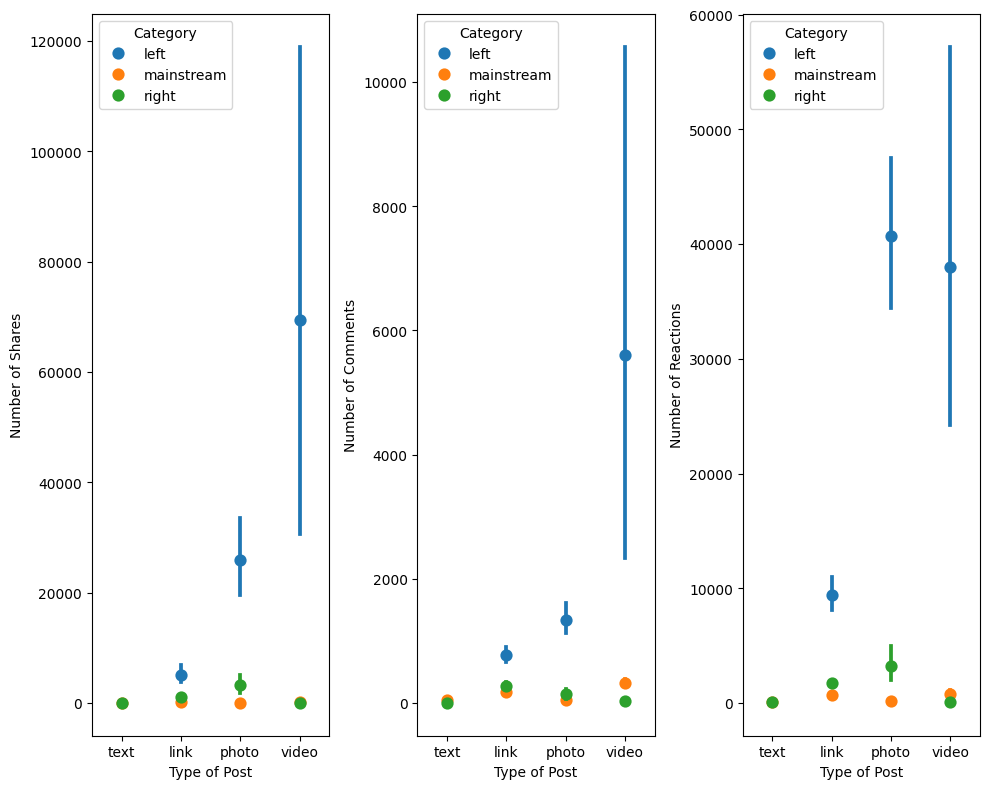

In [219]:
#order Category so that the graph x-axis labels are intuitive
df_H4['Category'] = pd.Categorical(posts['Category'], ['left','mainstream','right'])

#multiple adjacent plots for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,8))

sns.pointplot(x="Post_Type", y="share_count", hue='Category', linestyle='none',
              order=post_order, data=df_H4, ax=ax1)
ax1.set_xlabel("Type of Post")
ax1.set_ylabel("Number of Shares")

sns.pointplot(x="Post_Type", y="comment_count", hue='Category', linestyle='none', 
              order=post_order, data=df_H4, ax=ax2)
ax2.set_xlabel("Type of Post")
ax2.set_ylabel("Number of Comments")

sns.pointplot(x="Post_Type", y="reaction_count", hue='Category', linestyle='none', 
              order=post_order, data=df_H4, ax=ax3)
ax3.set_xlabel("Type of Post")
ax3.set_ylabel("Number of Reactions")

plt.tight_layout()

plt.show()

On each of these three metrics, there seems to be a relationship between type of post and the engagement with Facebook users. Video seems to outperform the other types. Let's investigate further.

#### Is the difference in Engagement Metrics between Type of Post statistically significant?

* H<sub>0</sub>: There is no real difference between the Engagement Metrics of different types of posts.
* H<sub>4</sub>: There is a real difference between the Engagement Metrics of different types of posts.

This time I am comparing interval variables with a categorical variable:

|  | Shares | Comments | Reactions | Type of Post |
|--|--------|----------|-----------|--------------|
| Description | The number of times a post has been shared. | The number of comments on a post. | The number of reactions to a post. | The kind of medium. | 
| Classifcation | Interval | Interval | Interval | Nominal |
| df Column | `share_count` | `comment_count` | `reaction_count` |`Post_Type` |
| Possible values | any integer | any integer | any integer | "text", "link", "photo", "video" |</table>

In [210]:
#run multiple regression to see if the relationship between share count
# and post type is statistically significant  
aov = smf.ols('share_count ~ C(Post_Type)', data=posts).fit()
aov.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            share_count   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     27.65
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           1.49e-17
Time:                        00:18:22   Log-Likelihood:                -25888.
No. Observations:                2212   AIC:                         5.178e+04
Df Residuals:                    2208   BIC:                         5.181e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1222.1957    696.989      1.754      0.080    -144.626    2589.018
C(Post_Type)[T.photo]  1.482e+04   2206.320      6.715      0.000    1.05e+04    1.91e+04
C(Post_Type)[T.text]  -1219.4457   1.47e+04     -0.083      0.934      -3e+04    2.75e+04
C(Post_Type)[T.video]  1.371e+04   2001.451      6.849      0.000    9782.173    1.76e+04
==============================================================================
Omnibus:                     5421.765   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         65403503.862
Skew:                          25.092   Prob(JB):                         0.00
Kurtosis:                     843.895   Cond. No.                         23.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### H<sub>4</sub> Discussion: Number of Shares vs Type of Post
The low R value shown indicates that the Type of Post only accounts for 3.6% of the variation in the Number of Shares, in this dataset.

* The p values for the links (intercept) and text fail to fall below the confidence interval p < 0.05.
* The p values for photos and video seem to be highly significant.
* The high skew and Kurtosis values indicate the extreme outliers are heavily skewed. I also failed to recognise this was communicated by the point plots' very long tails. The scatter plots below also demonstrate the presence of extreme outliers in the dataset.
* This data is not normally distributed, which is an assumption required for multiple regression.

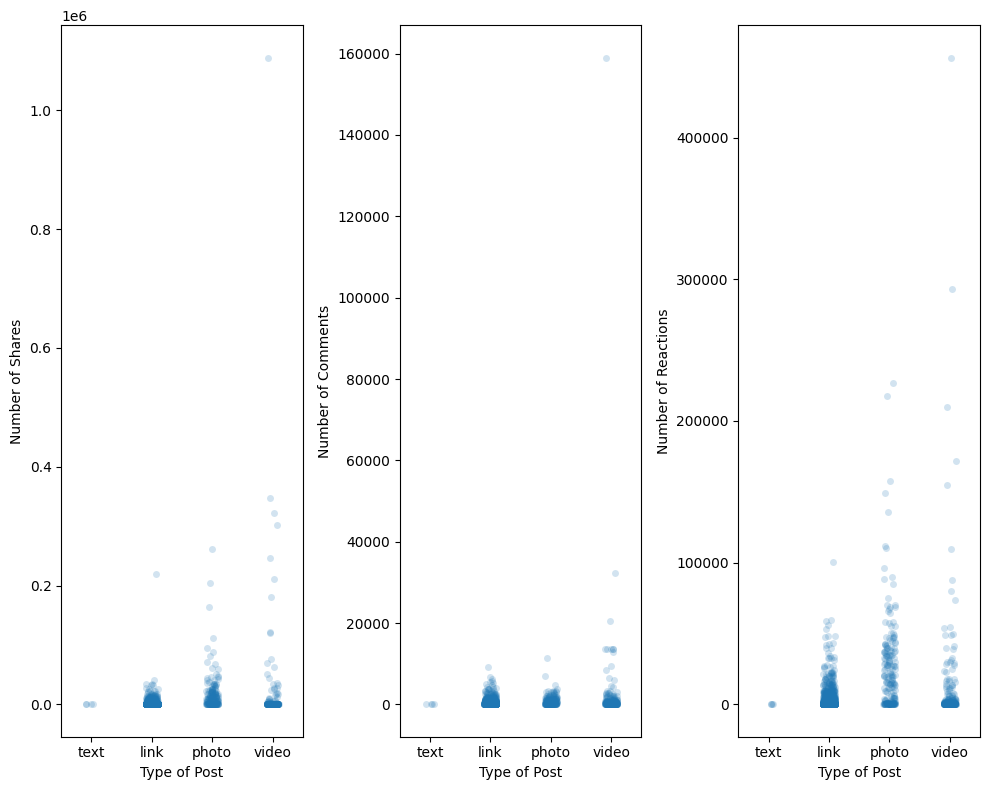

In [211]:
# Scatter plots with jitter to avoid overlap
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,8))
sns.stripplot(x='Post_Type', y='share_count', data=df_H4, jitter=True, alpha=0.2,
              order=post_order, ax=ax1)
ax1.set_xlabel("Type of Post")
ax1.set_ylabel("Number of Shares")

sns.stripplot(x='Post_Type', y='comment_count', data=df_H4, jitter=True, alpha=0.2,
              order=post_order, ax=ax2)
ax2.set_xlabel("Type of Post")
ax2.set_ylabel("Number of Comments")

sns.stripplot(x='Post_Type', y='reaction_count', data=df_H4, jitter=True, alpha=0.2,
              order=post_order, ax=ax3)
ax3.set_xlabel("Type of Post")
ax3.set_ylabel("Number of Reactions")

plt.tight_layout()

plt.show()

#### H<sub>4</sub> Results: Number of Shares vs Type of Post
If there was a strong relationship, we would expect these scatter plots to show some gradient shift patterns as greater or fewer points are mapped at the same position. The greatest difference between post types is seen the Number of Reactions for Photo (plot 3), but the lack of groupings indicate the spread is due to other variation rather than post type or even a subset type of photos. Interpreting these plots reinforces the analysis from the OLS regression results and I fail to reject the null hypothesis that there is no real difference between the engagement statistics of different types of posts.